# How does a plastic balanced network react to stimulation to a subpopulation of E neurons?

In [106]:
## Written by Alan Akil on 2/12/2020. The purpose of this code is to plot the results obtained from simulations
# of an I to E plastic balanced network recieving external stimulation to a subpopulation. 
# (This is in addition to having the Poisson layer driving the whole network). 
from sympy import symbols, Eq, solve
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sympy import Matrix
import scipy as sp
import seaborn as sns
# Load the .mat file.
mat_contents=sio.loadmat('./Stim_E_ei_ii.mat')


In [107]:
# Load all the variables
timeRecord = mat_contents['timeRecord'][0]/1000
JRec_ei_stim = mat_contents['JRec_ei_stim'][0]
JRec_ei_unstim = mat_contents['JRec_ei_unstim'][0]
# Jii = mat_contents['JRec_ii'][0]
e1Rate = mat_contents['e1RateT'][0]
e2Rate = mat_contents['e2RateT'][0]
iRate = mat_contents['iRateT'][0]
dtRate = mat_contents['dtRate'].squeeze()
eta_ei = mat_contents['eta_ei'].squeeze()
eta_ii = mat_contents['eta_ii'].squeeze()
Vector_Time_Rate = mat_contents['Vector_Time_Rate'][0]
T = mat_contents['T'][0,0].squeeze()
Tburn_raster = mat_contents['Tburn_raster'][0,0].squeeze()
T_start_stim = mat_contents['T_start_stim'][0,0].squeeze()
T_end_stim = mat_contents['T_end_stim'][0,0].squeeze()
rho_e = mat_contents['rho_e'].squeeze()
rho_i = mat_contents['rho_i'].squeeze()
tauSTDP = mat_contents['tauSTDP'].squeeze()
Jm = mat_contents['Jm']
Jxm = mat_contents['Jxm']
dt = mat_contents['dt'].squeeze()
seed = mat_contents['seed'].squeeze()
W = mat_contents['W']
Wx = mat_contents['Wx']
rx1 = mat_contents['rx1'].squeeze()
rx2 = mat_contents['rx2'].squeeze()
winsize = mat_contents['winsize'].squeeze()
Jmax_ei = mat_contents['Jmax_ei'].squeeze()
Jmax_ii = mat_contents['Jmax_ii'].squeeze()
Ie1Rec = mat_contents['Ie1Rec'].squeeze()
Ie2Rec = mat_contents['Ie2Rec'].squeeze()
IiRec = mat_contents['IiRec'].squeeze()
Ix1Rec = mat_contents['Ix1Rec'].squeeze()
Ix2Rec = mat_contents['Ix2Rec'].squeeze()
mVee_before_stim = mat_contents['mVee_before_stim']
mVii_before_stim = mat_contents['mVii_before_stim']
mVee_during_stim = mat_contents['mVee_during_stim']
mVii_during_stim = mat_contents['mVii_during_stim']
mVee_after_stim = mat_contents['mVee_after_stim']
mVii_after_stim = mat_contents['mVii_after_stim']
mR_before_stim = mat_contents['mR_before_stim']
mR_during_stim = mat_contents['mR_during_stim']
mR_after_stim = mat_contents['mR_after_stim']
c1 = mat_contents['c1'][0].squeeze()
c2 = mat_contents['c2'][0].squeeze()
N = mat_contents['N'][0,0].squeeze()
Ne1 = mat_contents['Ne1']
Ne2 = mat_contents['Ne2']
Ni = mat_contents['Ni']
Nx1 = mat_contents['Nx1']
Nx2 = mat_contents['Nx2']
Jei_initial_sims = mat_contents['Jei_initial'].squeeze()
Corrs_before = mat_contents['Corrs_before'][:,0]
Corrs_before = Corrs_before[~np.isnan(Corrs_before)]
Corrs_during = mat_contents['Corrs_during'][:,0]
Corrs_during = Corrs_during[~np.isnan(Corrs_during)]
Corrs_after = mat_contents['Corrs_after'][:,0]
Corrs_after = Corrs_after[~np.isnan(Corrs_after)]

In [109]:
c2

array(0, dtype=uint8)

In [3]:
mat_contents=sio.loadmat('../BurnVariablesCorrTestIC-3-20.mat')
# mat_contents=sio.loadmat('./BurnVariablesUncorr.8.19.2019.LargeN.mat')
# mat_contents=sio.loadmat('./BurnVariablesUncorrTestIC.mat')

Diff_E_rx_10 = mat_contents['R_e_sims'] - mat_contents['R_e_theory']
Diff_I_rx_10 = mat_contents['R_i_sims'] - mat_contents['R_i_theory']

J_initial_theory = mat_contents['Jm_ei']

mat_contents=sio.loadmat('../BurnVariablesCorrTestIC-3-20-Diff-rx.mat')
# mat_contents=sio.loadmat('./BurnVariablesUncorr.8.19.2019.LargeN.mat')
# mat_contents=sio.loadmat('./BurnVariablesUncorrTestIC.mat')

Diff_E_rx_15 = mat_contents['R_e_sims'] - mat_contents['R_e_theory']
Diff_I_rx_15 = mat_contents['R_i_sims'] - mat_contents['R_i_theory']



In [4]:
## Symbolic computation of the theoretical fixed point of the system for a set of different initial conditions.

jei = symbols('jei')
pex = 0.1; qx = 0.2;  qi = 0.2; qe = 0.8; pix=0.1;
pee = 0.1; pei = 0.1; pie = 0.1; pii = 0.1; jex = 180;
jix = 135; jee = 25; jie = 112.5; jii = -250;
taux = 10; taue = 8; taui = 4; tauc = 5; rx = 10/1000; tauSTDP = 200; alpha=4;
wex = pex*qx*jex
wee = pee*qe*jee 
wix = pex*qi*jix 
wei = pei*qi*jei 
wie = pie*qe*jie 
wii = pii*qi*jii
N = 10000

W = Matrix(([wee, wei], [wie, wii]))
Wx = np.array([wex, wix]).reshape((2,1))

indx = np.argmin(np.abs(J_initial_theory-Jei_initial_sims))
i = indx

Correction = np.array(([Diff_E_rx_10[i,0]/np.sqrt(N), Diff_I_rx_10[i,0]/np.sqrt(N)])).reshape((2,1))
r = -W.inv() @ (Wx * rx + Correction)
eq1 = Eq( (2*tauSTDP*r[0,0] - alpha) )
Je2i_theory = np.float(solve(eq1,jei)[0])
print(r.subs(jei,Je2i_theory))
print(Je2i_theory)

######################################
## We need to redefine some stuff to compute the theory of the stimulated period.

# For the time when it is stimulated.
rx=15/1000 # Total stimulation received by the stimulated pop.
Correction = np.array(([Diff_E_rx_15[i,0]/np.sqrt(N), Diff_I_rx_15[i,0]/np.sqrt(N)])).reshape((2,1))

r = -W.inv() @ (Wx * rx + Correction) # This correction needs to come from sims with rx=15/1000.
eq1 = Eq(- (2*tauSTDP*r[0,0] - alpha)* r[1,0] ) # We need to account for correlations here, see plot in next cell.
Je1i_theory = np.float(solve(eq1,jei)[0])
print(r.subs(jei,Je1i_theory))
# Je1i_theory = -184.7
print(Je1i_theory)

r_e_theory = 10
r_i_theory = 24

Matrix([[0.00999999999999993], [0.0239255852688368]])
-167.6158408688044
Matrix([[0.0100000000000000], [0.0267215912572548]])
-188.24354164659556


/opt/anaconda3/envs/bmnn/lib/python3.7/site-packages/sympy/core/relational.py:470: SymPyDeprecationWarning: 

Eq(expr) with rhs default to 0 has been deprecated since SymPy 1.5.
Use Eq(expr, 0) instead. See
https://github.com/sympy/sympy/issues/16587 for more info.

  deprecated_since_version="1.5"


No handles with labels found to put in legend.


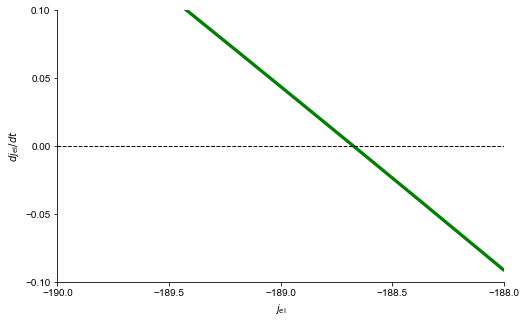

In [6]:
# Try changing the right hand side to fix the E rate.

## Dynamics of jie under vogels' plasticity applied to ie connections.
# Now shift the fixed point to the right.

# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.4, rc={"lines.linewidth":3.3})

# Theoretical plot of Jei as a function of time.
c=0
tauSTDP=200
alpha=1
n = 100000

jei = np.linspace(-250,-100,n)

djeidt = -(jei)*(-0.38214 * ((3.139773*jei)/(1.62*jei+90) +4+1450.86/(1.62*jei+90))/(0.18*jei+10) 
         - c2*( 125.195+ (0.375585*jei) )/ (55.55556+jei)**2 )


plt.plot(jei,djeidt,color='green')
plt.axhline(0,color='black',linestyle='--', linewidth=1)
#plt.axvline(0,color='black',linestyle='--')
plt.axvline(-150,color='black',linestyle='--',linewidth=1)


#r_e = ( 0.4125) / ( jie-41.6667 )
#r_i = ( 0.225-0.012jie )/( 41.6667 )

#print(r_e)
#print(r_i)

#print(jee[n-1])
plt.xlim(-190,-188)
plt.ylim(-.1,.1)
plt.xlabel(r'$j_{\rm ei}$')
plt.ylabel(r'$dj_{\rm ei}/dt$')
#plt.xticks(np.arange(0,51,step = 10),fontsize=15)
#plt.yticks(np.arange(-0.6,0.61,step = 0.3),fontsize=15)

leg = plt.legend(loc='lower left',fontsize=15,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)
# Change linewidth of legends.
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(4.0)


sns.despine()


#plt.savefig('./RvsJei.pdf',bbox_inches="tight",format="pdf")

plt.show()

In [9]:
# # Theory
# Je1i_theory = (0.054+0.004+0.016)/(-0.02**2)
# Je2i_theory = (0.036+0.004+0.016)/(-0.02**2)
# Jii_theory = (0.027+0.018+0.072)/(-0.02**2)
timeRecord.shape

(300000,)

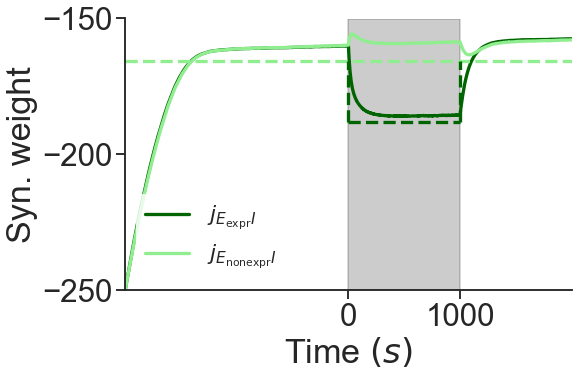

In [24]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})

burnTime = T_start_stim/1000
# Shade area where laser is ON.
ax.axvspan(0, T_end_stim/1000 - T_start_stim/1000, alpha=0.2, color='black')

# plt.plot([0, T_end_stim/1000-T_start_stim/1000], [Je1i_theory, Je1i_theory], linestyle='--',color='darkgreen')
# plt.plot([0, TotalTime/1000], [Jii_theory, Jii_theory], linestyle='--',color='purple')
# plt.plot([0-T_start_stim/1000, TotalTime/1000-T_start_stim/1000], [Je2i_theory, Je2i_theory], linestyle='--',color='lightgreen')
# plt.plot([0, 0], [Je1i_theory, Je2i_theory], linestyle='--',color='darkgreen')
# plt.plot([T_end_stim/1000-T_start_stim/1000, T_end_stim/1000-T_start_stim/1000], 
#          [Je1i_theory, Je2i_theory], linestyle='--',color='darkgreen')


plt.plot( timeRecord-burnTime , JRec_ei_stim,color='darkgreen',label=r'$j_{E_{\rm expr} I}$')
plt.plot( timeRecord-burnTime , JRec_ei_unstim,color='lightgreen',label=r'$j_{E_{\rm nonexpr} I}$')
# plt.plot( timeRecord , Jii,color='purple',label=r'$j_{II}$')

plt.plot([-2000,2000], [-165.79679419615053,-165.79679419615053], color='lightgreen',linestyle='--')

plt.plot([-0,1000], [-188,-188], color='darkgreen',linestyle='--')

plt.plot([0,0], [-188,-165.79679419615053], color='darkgreen',linestyle='--')

plt.plot([1000,1000], [-188,-165.79679419615053], color='darkgreen',linestyle='--')



plt.xlabel(r'Time $(s)$')
plt.ylabel(r'Syn. weight')
plt.yticks((-250,-200,-150))
plt.xlim(-burnTime,T/1000-burnTime)
plt.xticks((0,1000))
plt.ylim(-250, -150)

leg = plt.legend(loc='lower left',fontsize=22,frameon='none')
leg.get_frame().set_linewidth(0.0)
# Change linewidth of legends.
#for legobj in leg.legendHandles:
#    legobj.set_linewidth(3.0)

sns.despine()

# fig.savefig("/Users/alan/Desktop/Research/NewPaper/Figure4/Jmean_E_stim.pdf", bbox_inches="tight")    

fig.savefig("./PlotsReview_BNs/Fig6-stimulation/Jmean_E_stim.pdf", bbox_inches="tight")



plt.show()

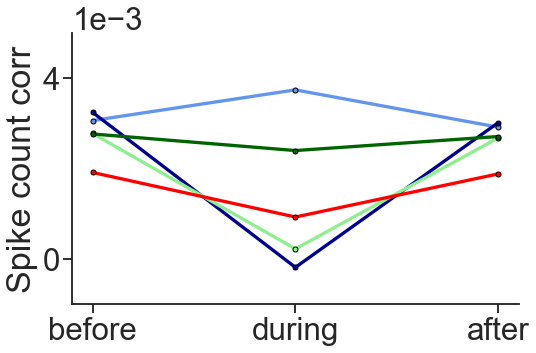

In [44]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})

mRe1e1 = [mR_before_stim[0,0],mR_during_stim[0,0],mR_after_stim[0,0]]
mRe1e2 = [mR_before_stim[0,1],mR_during_stim[0,1],mR_after_stim[0,1]]
mRe1i = [mR_before_stim[0,2],mR_during_stim[0,2],mR_after_stim[0,2]]
mRe2i = [mR_before_stim[1,2],mR_during_stim[1,2],mR_after_stim[1,2]]
mRii = [mR_before_stim[2,2],mR_during_stim[2,2],mR_after_stim[2,2]]

myxticks = ['before','during','after']

line1 = plt.plot( myxticks , mRe1e1,color='cornflowerblue',label=r'$E_{\rm expr}E_{\rm expr}$',marker='o',markersize=5,
            markeredgecolor='black')
line2 = plt.plot( myxticks , mRe1e2,color='darkblue',label=r'$E_{\rm expr}E_{\rm nonexpr}$',marker='o',markersize=5,
            markeredgecolor='black')
line3 = plt.plot( myxticks , mRe1i,color='lightgreen',label=r'$E_{\rm expr}I$',marker='o',markersize=5,
            markeredgecolor='black')
line4 = plt.plot( myxticks , mRe2i,color='darkgreen',label=r'$E_{\rm nonexpr}I$',marker='o',markersize=5,
            markeredgecolor='black')
line5 = plt.plot( myxticks , mRii,color='red',label=r'$II$',marker='o',markersize=5,
            markeredgecolor='black')

plt.ylabel(r'Spike count corr')
plt.ylim(-.001, 0.005)
plt.yticks((0,0.004))
ax.ticklabel_format(style='sci',scilimits=(-1,4),axis='y')

# leg = plt.legend(loc='lower left',fontsize=20,frameon='none')
# leg.get_frame().set_linewidth(0.0)

sns.despine()

# fig.savefig("/Users/alan/NewPaper/Figure5/Corr_mean_E_stim.pdf", bbox_inches="tight")    

fig.savefig("./PlotsReview_BNs/Fig6-stimulation/Corr_mean_E_stim.pdf", bbox_inches="tight")



plt.show()

NameError: name 'Je1i_before' is not defined

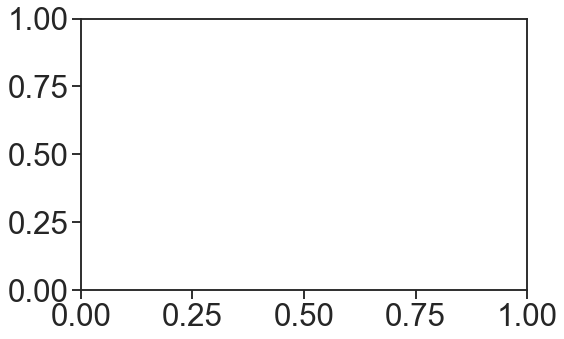

In [14]:
# Plot the distribution of correlations
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})

bins=np.histogram(np.hstack((Je1i_before,Je1i_during,Je1i_after)), bins=80)[1] #get the bin edges

sns.distplot(Je1i_before,kde=False,color='blue',bins=bins)
plt.axvline(np.mean(Je1i_before), label = r'before',color='blue')
sns.distplot(Je1i_during,kde=False,color='green',bins=bins)
plt.axvline(np.mean(Je1i_during), label = r'during',color='green')
sns.distplot(Je1i_after,kde=False,color='red',bins=bins)
plt.axvline(np.mean(Je1i_after), label = r'after',color='red')

plt.xlabel('Synaptic weights')
plt.ylabel('Count')
plt.yticks(())
plt.xlim((-300,0))

leg = plt.legend(loc='upper left',fontsize=20,frameon='none')
leg.get_frame().set_linewidth(0.0)

sns.despine()
plt.show()

# fig.savefig("/Users/alan/NewPaper/Figure5/J_dist_E_stim.pdf", bbox_inches="tight")    

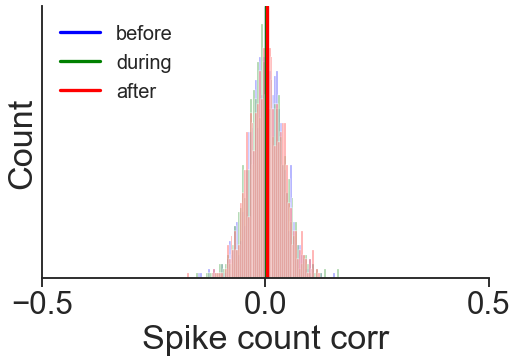

In [48]:
# Plot the distribution of correlations
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})

bins=np.histogram(np.hstack((Corrs_before,Corrs_during,Corrs_after)), bins=80)[1] #get the bin edges

sns.distplot(Corrs_before,kde=False,color='blue',bins=bins)
plt.axvline(np.mean(Corrs_before), label = r'before',color='blue')
sns.distplot(Corrs_during,kde=False,color='green',bins=bins)
plt.axvline(np.mean(Corrs_during), label = r'during',color='green')
sns.distplot(Corrs_after,kde=False,color='red',bins=bins)
plt.axvline(np.mean(Corrs_after), label = r'after',color='red')

plt.xlabel('Spike count corr')
plt.ylabel('Count')
plt.yticks(())
plt.xlim((-1/2,1/2))
plt.xticks((-0.5,0,0.5))

leg = plt.legend(loc='upper left',fontsize=20,frameon='none')
leg.get_frame().set_linewidth(0.0)

sns.despine()
plt.show()

# fig.savefig("/Users/alan/Desktop/Research/NewPaper/Figure4/Corr_dist_E_stim.pdf", bbox_inches="tight")

fig.savefig("./PlotsReview_BNs/Fig6-stimulation/Corr_dist_E_stim.pdf", bbox_inches="tight")


In [15]:
# Slide a window over the rates to smooth them.

e1Rate.shape
window = 50
Num_points = np.int(len(e1Rate) - window)

e1Rate_New = np.zeros((Num_points,1))
e2Rate_New = np.zeros((Num_points,1))
iRate_New = np.zeros((Num_points,1))



for i in range(Num_points):
    e1Rate_New[i,0] = np.mean(e1Rate[i:i+window])
    e2Rate_New[i,0] = np.mean(e2Rate[i:i+window])
    iRate_New[i,0] = np.mean(iRate[i:i+window])

    


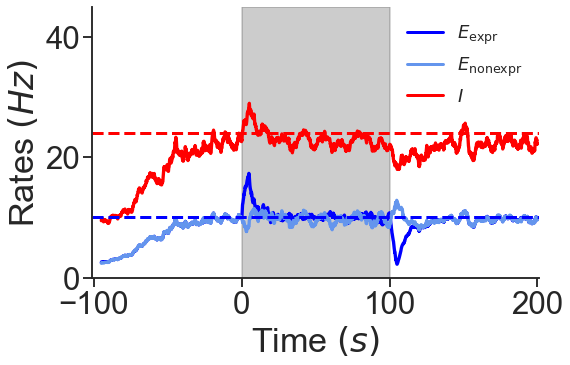

In [17]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})

# Shade area where laser is ON.
ax.axvspan(0, 100, alpha=0.2, color='black')

plt.plot( np.linspace(-burnTime+5,200,num=Num_points) , 1000*e1Rate_New,color='blue',label=r'$E_{\rm expr}$')
plt.plot( np.linspace(-burnTime+5,200,num=Num_points) , 1000*e2Rate_New,color='cornflowerblue',label=r'$E_{\rm nonexpr}$')
plt.plot( np.linspace(-burnTime+5,200,num=Num_points) , 1000*iRate_New,color='red',label=r'$I$')

plt.axhline( y=r_e_theory,color='blue',linewidth=3,linestyle='--')
plt.axhline( y=r_i_theory,color='red',linewidth=3,linestyle='--')

plt.xlabel(r'Time $(s)$')
plt.ylabel(r'Rates $(Hz)$')
plt.yticks((0,20,40))
plt.xlim(-101,201)
plt.ylim(-0.1, 45)
#plt.xticks( np.arange(0, 210, step=50),fontsize=22)

sns.despine()

leg = plt.legend(loc='upper right',fontsize=18,frameon='none')
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# fig.savefig("/Users/alan/Desktop/Research/NewPaper/Figure4/FR_E_stim.pdf", bbox_inches="tight")    

plt.show()

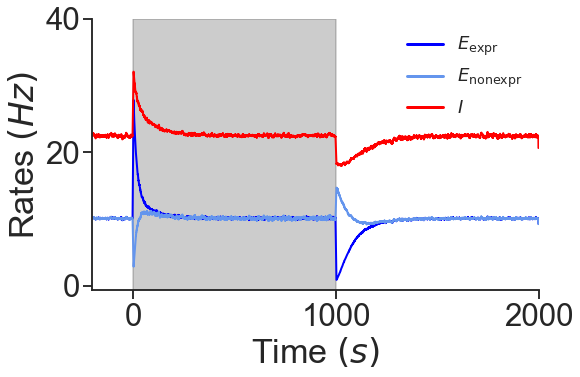

In [63]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":2})

burnTime = T_start_stim/1000
# Shade area where laser is ON.
ax.axvspan(0, T_end_stim/1000 - T_start_stim/1000, alpha=0.2, color='black')

# plt.plot( Vector_Time_Rate - burnTime, 1000*e1Rate,color='blue',label=r'$E_{\rm expr}$')
# plt.plot( Vector_Time_Rate - burnTime,1000*e2Rate,color='cornflowerblue',label=r'$E_{\rm nonexpr}$')
# plt.plot( Vector_Time_Rate - burnTime,1000*iRate,color='red',label=r'$I$')

window_size = 50 # len(mean_Jei_recorded[0,:])
window_conv = np.ones((1,window_size)) / window_size
window_conv = window_conv.squeeze()

plt.plot( Vector_Time_Rate[:-20] - burnTime, 1000*np.convolve(e1Rate,window_conv,mode='same')[:-20],
         color='blue',label=r'$E_{\rm expr}$')
plt.plot( Vector_Time_Rate[:-20] - burnTime,1000*np.convolve(e2Rate,window_conv,mode='same')[:-20],
         color='cornflowerblue',label=r'$E_{\rm nonexpr}$')
plt.plot( Vector_Time_Rate[:-20] - burnTime,1000*np.convolve(iRate,window_conv,mode='same')[:-20],
         color='red',label=r'$I$')

# plt.axhline( y=r_e_theory,color='blue',linewidth=3,linestyle='--')
# plt.axhline( y=r_i_theory,color='red',linewidth=3,linestyle='--')

plt.xlabel(r'Time $(s)$')
plt.ylabel(r'Rates $(Hz)$')
plt.yticks((0,20,40))
plt.xlim(-200,2000)
# plt.ylim(-0.1, 45)
#plt.xticks( np.arange(0, 210, step=50),fontsize=22)

sns.despine()

leg = plt.legend(loc='upper right',fontsize=18,frameon='none')
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)

# fig.savefig("/Users/alan/Desktop/Research/NewPaper/Figure4/FR_E_stim.pdf", bbox_inches="tight")    

fig.savefig("./PlotsReview_BNs/Fig6-stimulation/FR_E_stim.pdf", bbox_inches="tight")

plt.show()

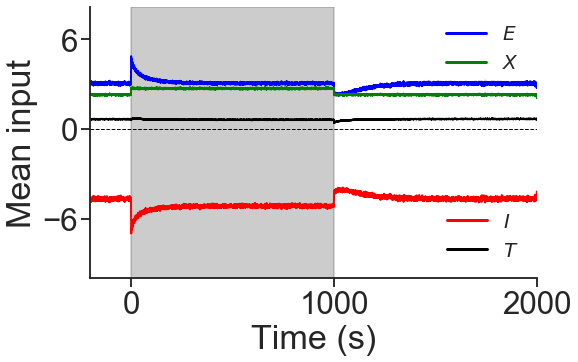

In [105]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":2})

burnTime = T_start_stim/1000
# Shade area where laser is ON.
ax.axvspan(0, T_end_stim/1000 - T_start_stim/1000, alpha=0.2, color='black')

# plt.plot( timeRecord-burnTime, Ie1Rec,color='blue',label=r'$E_{\rm expr}$')
# plt.plot( timeRecord-burnTime,Ie2Rec,color='cornflowerblue',label=r'$E_{\rm nonexpr}$')
# plt.plot( timeRecord-burnTime,IiRec,color='red',label=r'$I$')
# plt.plot( timeRecord-burnTime,Ix1Rec,color='purple',label=r'$X_1$')
# plt.plot( timeRecord-burnTime,Ix2Rec,color='darkgreen',label=r'$X_2$')

# plt.plot( timeRecord-burnTime,Ie1Rec+Ie2Rec+Ix1Rec+Ix2Rec+IiRec,
#          color='black',label=r'$T$')


window_size = 100 # len(mean_Jei_recorded[0,:])
window_conv = np.ones((1,window_size)) / window_size
window_conv = window_conv.squeeze()

line1, = plt.plot( timeRecord[:-40]-burnTime,np.convolve(Ie1Rec+Ie2Rec,window_conv,mode='same')[:-40],
                  color='blue',label=r'$E$')
line2, = plt.plot( timeRecord[:-40]-burnTime,np.convolve(Ix1Rec+Ix2Rec,window_conv,mode='same')[:-40],
                  color='green',label=r'$X$')
line3, = plt.plot( timeRecord[:-40]-burnTime,np.convolve(IiRec,window_conv,mode='same')[:-40],
                  color='red',label=r'$I$')
line4, = plt.plot( timeRecord[:-40]-burnTime,np.convolve(Ie1Rec+Ie2Rec+Ix1Rec+Ix2Rec+IiRec,window_conv,mode='same')[:-40],
                  color='black',label=r'$T$')
# plt.plot( timeRecord-burnTime,IiRec,color='red',label=r'$I$')
# plt.plot( timeRecord-burnTime,Ix1Rec,color='purple',label=r'$X_1$')
# plt.plot( timeRecord-burnTime,Ix2Rec,color='darkgreen',label=r'$X_2$')
# plt.plot( timeRecord-burnTime,Ie1Rec+Ie2Rec+Ix1Rec+Ix2Rec+IiRec,
#          color='black',label=r'$T$')

leg = plt.legend(handles=[line1,line2],loc='upper right',fontsize=20,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)

ax = plt.gca().add_artist(leg)

leg1 = plt.legend(handles=[line3,line4],loc='lower right',fontsize=20,frameon='none',markerscale=1)
leg1.get_frame().set_linewidth(0.0)

plt.axhline(y=0,linestyle='--',color='black',linewidth=1)

plt.xlabel(r'Time (s)')
plt.ylabel(r'Mean input')
plt.yticks((-6,0,6))
plt.xlim((-200,2000))
plt.ylim((-10,8.2))
#plt.xticks( np.arange(0, 210, step=50),fontsize=22)

sns.despine()

# leg = plt.legend(loc='upper right',fontsize=18,frameon='none')
# leg.get_frame().set_linewidth(0.0)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.0)
for legobj in leg1.legendHandles:
    legobj.set_linewidth(3.0)


fig.savefig("./PlotsReview_BNs/Fig6-stimulation/inputcurrents_E_stim.pdf", bbox_inches="tight")


plt.show()